# Stock Prediction Model

## Dependencies

### Library Installation (if needed)

In [11]:
#! pip install yfinance pandas numpy matplotlib lightgbm torch tensorflow keras

### Importing Required Libraries

In [12]:
from datetime import datetime
import matplotlib.pyplot as plt
import lightgbm as lgb
import yfinance as yf
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMRegressor
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD

### Variables

In [13]:
print_errors = True
build_new_dataset = True
symbols = 'simple' # 'simple' or 'advanced'. simple are the tickers from the screener notebook and advanced are all of the tickers in 'filtered_tickers'

## Data Preparation

In [14]:
if symbols == 'simple':
    symbols = pd.read_csv('../data/simple_screener_results.csv')['Ticker'].tolist()
if symbols == 'advanced':
    symbols = pd.read_csv('../data/filtered_tickers.csv')['Ticker'].tolist()

symbols = pd.Series(symbols).unique()
symbols

array(['MATAS.CO', 'TRIFOR.CO', 'QQ.L', 'RNMBY', 'SAABF', 'BCKIY',
       'BAESY', 'IVSO.ST', 'NSKFF', 'GMAB', 'GN.CO', 'NVDA', 'LLY',
       'DANSKE.CO', 'CARL-B.CO', 'MAERSK-B.CO', 'RBREW.CO', 'ISS.CO',
       'DSV.CO', 'SCHO.CO', 'NETC.CO', 'JYSK.CO', 'ABBN.SW', 'TER',
       'PARKEN.CO', 'NFLX', 'TRMD-A.CO', 'STG.CO', 'NOVO-B.CO', 'EQNR',
       'NKT.CO', 'NSIS-B.CO', 'KCC.OL'], dtype=object)

#### Download annual financial data

In [ ]:
if build_new_dataset:
    df = pd.DataFrame()
    for symbol in tqdm(symbols):
        ticker_df = pd.DataFrame()
        ticker = yf.Ticker(symbol)
        try:
            # Latest earning data
            latest_earning_date = ticker.quarterly_cash_flow.columns.tolist()[0]
            latest_data = {'Ticker': symbol, 'Date': latest_earning_date}
            ticker_df['1 Year Future Change'] = np.nan

            try:
                latest_data['Sector'] = ticker.info['sector']
            except:
                latest_data['Sector'] = 'Unknown'
                
            try:
                latest_data['Industry'] = ticker.info['industry']
            except:
                latest_data['Industry'] = 'Unknown'

            for column in ticker.quarterly_cash_flow[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_cash_flow[latest_earning_date][column]

            for column in ticker.quarterly_balance_sheet[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_balance_sheet[latest_earning_date][column]

            for column in ticker.quarterly_income_stmt[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_income_stmt[latest_earning_date][column]

            ticker_df = pd.concat([ticker_df, pd.DataFrame([latest_data])], ignore_index=True)

            # Annual data
            earning_dates = ticker.cash_flow.columns.tolist()
            price_data = yf.download(symbol, period='10y', rounding=False, progress=False)
            cash_flow = ticker.cash_flow
            cash_flow_columns = cash_flow[earning_dates[0]].keys().tolist()
            balance_sheet = ticker.balance_sheet
            balance_sheet_columns = balance_sheet[earning_dates[0]].keys().tolist()
            income_statement = ticker.income_stmt
            income_statement_columns = income_statement[earning_dates[0]].keys().tolist()
            earning_date_data = {'Ticker': symbol, 'Date': earning_date}
            for earning_date in earning_dates:
                got_price = False
                day_offset = 0
                while(got_price==False and day_offset > -6):
                    try:
                        earning_date_data['1 Year Future Change'] = float(price_data.loc[earning_date + pd.Timedelta(days=day_offset+365,), ('Close', symbol)]) / float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        got_price = True
                    except:
                        day_offset += -1

                try:
                    earning_date_data['Sector'] = ticker.info['sector']
                except:
                    earning_date_data['Sector'] = 'Unknown'
                
                try:
                    earning_date_data['Industry'] = ticker.info['industry']
                except:
                    earning_date_data['Industry'] = 'Unknown'

                for column in cash_flow_columns:
                    earning_date_data[column] = cash_flow[earning_date][column]

                for column in balance_sheet_columns:
                    earning_date_data[column] = balance_sheet[earning_date][column]

                for column in income_statement_columns:
                    earning_date_data[column] = income_statement[earning_date][column]
                
                if got_price:
                    ticker_df = pd.concat([ticker_df, pd.DataFrame([earning_date_data])], ignore_index=True)

            imputer = SimpleImputer()
            wanted_columns = ticker_df.columns.drop(['Ticker', 'Date', '1 Year Future Change', 'Sector', 'Industry'])
            for column in wanted_columns:
                if not ticker_df[column].isna().all():
                    ticker_df[column] = imputer.fit_transform(ticker_df[[column]])
            
            df = pd.concat([df, ticker_df], ignore_index=True)
        except Exception as error:
            if print_errors:
                print(f'Error for {symbol}: {error}')
            continue

    wanted_columns = df.columns.drop(['Ticker', 'Date', '1 Year Future Change', 'Sector', 'Industry'])
    for column in wanted_columns:
        df[column] = imputer.fit_transform(df[[column]])
        scaler = StandardScaler()
        scaler.fit(df[[column]])
        df[column] = scaler.transform(df[[column]])

    le = LabelEncoder()
    for non_numeric_column in ['Sector', 'Industry']:
        df[non_numeric_column] = df[non_numeric_column].astype(str)
        le.fit(df[non_numeric_column])
        df[non_numeric_column] = le.transform(df[non_numeric_column])

    df.to_csv('../data/earnings_data.csv', index=False)
else:
    df = pd.read_csv('../data/earnings_data.csv')

  3%|▎         | 1/33 [00:02<01:07,  2.12s/it]

Error for MATAS.CO: name 'earning_date' is not defined


  6%|▌         | 2/33 [00:04<01:07,  2.19s/it]

Error for TRIFOR.CO: name 'earning_date' is not defined


  9%|▉         | 3/33 [00:04<00:40,  1.36s/it]

Error for QQ.L: list index out of range


 12%|█▏        | 4/33 [00:07<00:50,  1.75s/it]

Error for RNMBY: name 'earning_date' is not defined


 15%|█▌        | 5/33 [00:09<00:52,  1.87s/it]

Error for SAABF: name 'earning_date' is not defined


 21%|██        | 7/33 [00:09<00:24,  1.07it/s]

Error for BCKIY: list index out of range
Error for BAESY: list index out of range


 24%|██▍       | 8/33 [00:12<00:35,  1.43s/it]

Error for IVSO.ST: name 'earning_date' is not defined


 27%|██▋       | 9/33 [00:13<00:37,  1.57s/it]

Error for NSKFF: name 'earning_date' is not defined


 30%|███       | 10/33 [00:15<00:39,  1.71s/it]

Error for GMAB: name 'earning_date' is not defined


 33%|███▎      | 11/33 [00:17<00:39,  1.78s/it]

Error for GN.CO: name 'earning_date' is not defined


 36%|███▋      | 12/33 [00:20<00:39,  1.89s/it]

Error for NVDA: name 'earning_date' is not defined


 39%|███▉      | 13/33 [00:21<00:38,  1.91s/it]

Error for LLY: name 'earning_date' is not defined


 45%|████▌     | 15/33 [00:23<00:24,  1.34s/it]

Error for DANSKE.CO: name 'earning_date' is not defined
Error for CARL-B.CO: list index out of range


 48%|████▊     | 16/33 [00:26<00:29,  1.75s/it]

Error for MAERSK-B.CO: name 'earning_date' is not defined


 55%|█████▍    | 18/33 [00:28<00:20,  1.34s/it]

Error for RBREW.CO: name 'earning_date' is not defined
Error for ISS.CO: list index out of range


 58%|█████▊    | 19/33 [00:31<00:23,  1.65s/it]

Error for DSV.CO: name 'earning_date' is not defined


 61%|██████    | 20/33 [00:33<00:24,  1.92s/it]

Error for SCHO.CO: name 'earning_date' is not defined


 64%|██████▎   | 21/33 [00:36<00:25,  2.10s/it]

Error for NETC.CO: name 'earning_date' is not defined


 67%|██████▋   | 22/33 [00:38<00:23,  2.12s/it]

Error for JYSK.CO: name 'earning_date' is not defined


 70%|██████▉   | 23/33 [00:40<00:21,  2.19s/it]

Error for ABBN.SW: name 'earning_date' is not defined


 73%|███████▎  | 24/33 [00:43<00:20,  2.28s/it]

Error for TER: name 'earning_date' is not defined


 76%|███████▌  | 25/33 [00:45<00:18,  2.26s/it]

Error for PARKEN.CO: name 'earning_date' is not defined


 79%|███████▉  | 26/33 [00:47<00:16,  2.30s/it]

Error for NFLX: name 'earning_date' is not defined


 82%|████████▏ | 27/33 [00:50<00:14,  2.38s/it]

Error for TRMD-A.CO: name 'earning_date' is not defined


 85%|████████▍ | 28/33 [00:52<00:11,  2.23s/it]

Error for STG.CO: name 'earning_date' is not defined


 88%|████████▊ | 29/33 [00:54<00:08,  2.14s/it]

Error for NOVO-B.CO: name 'earning_date' is not defined


 91%|█████████ | 30/33 [00:56<00:06,  2.12s/it]

Error for EQNR: name 'earning_date' is not defined


 94%|█████████▍| 31/33 [00:58<00:04,  2.02s/it]

Error for NKT.CO: name 'earning_date' is not defined


 97%|█████████▋| 32/33 [01:00<00:01,  2.00s/it]

Error for NSIS-B.CO: name 'earning_date' is not defined


100%|██████████| 33/33 [01:01<00:00,  1.88s/it]

Error for KCC.OL: name 'earning_date' is not defined


KeyError: "['Ticker', 'Date', '1 Year Future Change', 'Sector', 'Industry'] not found in axis"

### Short visualisation

In [ ]:
df

,Ticker,Date,1 Year Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,...,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Change In Dividend Payable,Depletion,Investmentsin Subsidiariesat Cost,Restricted Common Stock,Net Income From Tax Loss Carryforward
0,AA,2023-12-31,0.103476,0,5,-0.022618,0.075749,0.059613,-0.061755,0.063339,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
1,AA,2022-12-31,-0.261057,0,5,-0.021928,0.053653,0.059634,-0.061787,0.063386,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
2,AA,2021-12-31,-0.226370,0,5,-0.021762,0.069120,0.059256,-0.061659,0.063468,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
3,AA,2020-12-31,1.590461,0,5,-0.022103,0.066174,0.059501,-0.061734,0.063398,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4,AAT,2023-12-31,0.202075,8,96,-0.022136,0.000000,0.059580,-0.061729,0.063749,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4950,ZBRA,2020-12-31,0.548669,9,25,-0.021838,0.063081,0.059557,-0.061634,0.063758,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4951,ZUMZ,2024-01-31,-0.050670,2,7,-0.022235,0.075749,0.059620,-0.061775,0.063807,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4952,ZUMZ,2023-01-31,-0.335269,2,7,-0.022253,0.071866,0.059627,-0.061782,0.063802,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4953,ZUMZ,2022-01-31,-0.425362,2,7,-0.022124,0.067185,0.059634,-0.061788,0.063811,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0


### Splitting

In [ ]:
feature_columns = df.columns.drop(['Ticker', 'Date', '1 Year Future Change'])

# Step 3: Define the window size for sequences
k = 3  # Number of time steps in each sequence

# Step 4: Preprocess data - create training sequences and targets
sequences = []
targets = []
grouped = df.groupby('Ticker')
for ticker, group in grouped:
    group = group.sort_values('Date')
    df_features = group[feature_columns]
    df_target = group['1 Year Future Change'].values
    n_dates = len(group)
    for j in range(k - 1, n_dates - 1):
        if not np.isnan(df_target[j]):  # Exclude sequences with 'NaN' targets
            seq = df_features[j - k + 1 : j + 1]
            target = df_target[j]
            sequences.append(seq)
            targets.append(target)

sequences_train, sequences_test, targets_train, targets_test = train_test_split(
    sequences, targets, test_size=0.2, random_state=42
)

# Step 5: Create a custom Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = [torch.tensor(seq.values, dtype=torch.float32) for seq in sequences]
        self.targets = torch.tensor(targets, dtype=torch.float32)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

# Step 6: Create DataLoader
train_dataset = TimeSeriesDataset(sequences_train, targets_train)
test_dataset = TimeSeriesDataset(sequences_test, targets_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Model Training

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Take the last time step
        out = self.fc(out)
        return out

num_features = len(feature_columns)
model = LSTMModel(input_size=num_features, hidden_size=500, num_layers=3, output_size=1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    model.train()
    for seqs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(seqs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


## Testing and benchmarking

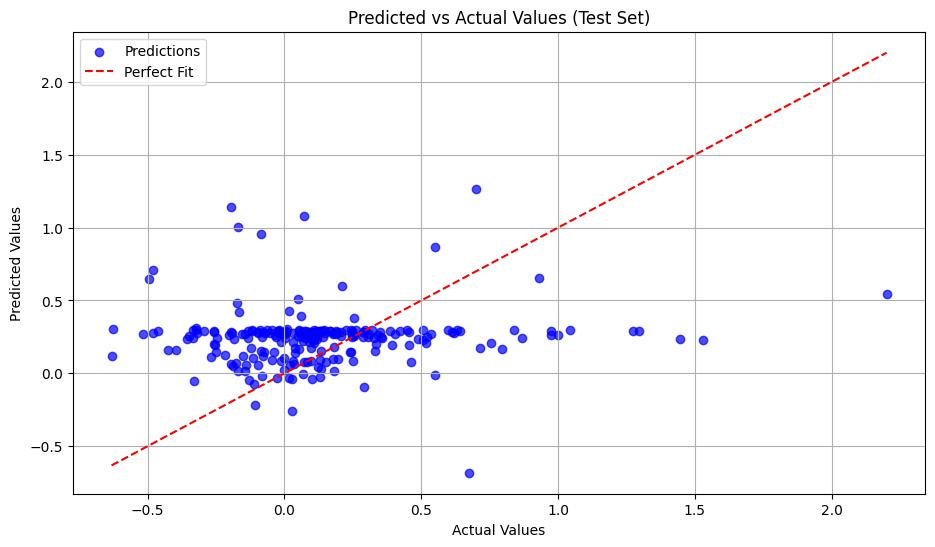

MAE: 0.3038
MSE: 0.1742
R²: -0.2930


In [ ]:
model.eval()
with torch.no_grad():
    all_predictions = []
    all_targets = []
    for seqs, labels in test_loader:
        outputs = model(seqs)
        all_predictions.append(outputs.squeeze().cpu().numpy())
        all_targets.append(labels.cpu().numpy())
all_predictions = np.concatenate(all_predictions)
all_targets = np.concatenate(all_targets)

plt.figure(figsize=(11, 6))
plt.scatter(all_targets, all_predictions, alpha=0.7, color='blue', label='Predictions')
plt.plot([all_targets.min(), all_targets.max()], [all_targets.min(), all_targets.max()], 
         color='red', linestyle='--', label='Perfect Fit')
plt.title('Predicted vs Actual Values (Test Set)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

mae = mean_absolute_error(all_targets, all_predictions)
mse = mean_squared_error(all_targets, all_predictions)
r2 = r2_score(all_targets, all_predictions)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

In [ ]:
for ticker, group in grouped:
    group = group.sort_values('Date')
    df_features = group[feature_columns]
    if len(group) >= k:
        pred_seq = df_features[-k:]  # Last k time steps including "Latest"
        pred_seq_tensor = torch.tensor(pred_seq.values, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            prediction = model(pred_seq_tensor)
        print(f"Prediction for {ticker} Latest: {prediction.item()}")

Prediction for AA Latest: 0.13356834650039673
Prediction for AAT Latest: 0.2780730724334717
Prediction for ABM Latest: 0.2960965633392334
Prediction for ABR Latest: 0.2824384570121765
Prediction for ABT Latest: 0.2623392939567566
Prediction for ACI Latest: 0.23652680218219757
Prediction for ACLS Latest: 0.2927273213863373
Prediction for ACM Latest: 0.18328072130680084
Prediction for ACP Latest: 0.21828795969486237
Prediction for ACRE Latest: 0.2811320424079895
Prediction for ACT Latest: 0.2711137533187866
Prediction for ACTG Latest: 0.18586041033267975
Prediction for ADBE Latest: 0.29496774077415466
Prediction for ADC Latest: 0.28139203786849976
Prediction for ADI Latest: 0.29310446977615356
Prediction for ADM Latest: 0.1940869390964508
Prediction for ADP Latest: 0.29474127292633057
Prediction for ADT Latest: 0.2902235984802246
Prediction for ADTN Latest: -0.0067701321095228195
Prediction for ADUS Latest: 0.2669515311717987
Prediction for AEE Latest: 0.2950308918952942
Prediction for A